<a href="https://colab.research.google.com/github/chrisrichardson/intrusion-thermal/blob/main/Thermal_Intrusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded


In [55]:
def keff(T):
    '''
    Calculate effective value of diffusivity as
    a function of temperature taking into account Latent Heat of Fusion
    kappa = k / rho [ Cp + L/deltaT ]
    Typical values:
    Density rho = 3000 kg/m3
    Thermal conductivity k = 3 W/m/K
    Heat capacity Cp = 1000 J/kg/K
    Latent heat of fusion L = 500000 J/kg
    Melting interval deltaT = 200 K
    '''

    # Melting point
    Tm = 980

    # ratio L/(Cp * deltaT)
    L_CpdT = 2.1

    # Relative value for k
    keff = 1.0/(1.0 + L_CpdT * (T>Tm))
    return keff

In [56]:
def matA(T, gam):
    ''' Discretisation of the diffusion equation:
    dT/dt = k(T) d2T/dx2
    using a backward-Euler method in 1D, resulting in a
    tridiagonal matrix system A.T(n+1) = T(n).
    Use a tridiagonal solver (e.g. scipy solve_banded).
    Boundary conditions are set to zero flux at x=0 (i.e. symmetric)
    and to fixed T on the other edge of the domain.
    '''
    nr = len(T)
    k = keff(T)
    A = np.zeros((3, nr))
    for i in range(1, nr-1):
        A[0, i+1] = -gam * k[i]
        A[1, i] = 1.0 + 2.0 * gam * k[i]
        A[2, i-1] = -gam * k[i]

    # B.C. at x=0, no flux.
    A[0, 1] = -1.0 * gam*k[0]
    A[1, 0] = 1.0 + 1.0 * gam*k[0]

    #B.C. at x=nr*dx
    A[1, nr-1] = 1.0
    A[2, nr-2] = 0.0

    return A


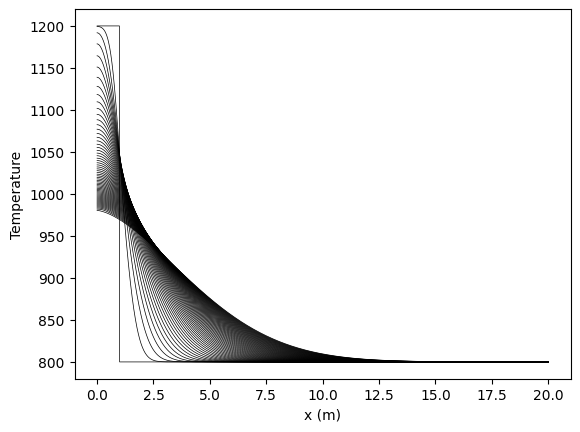

In [62]:
# Set up problem

# width of intrusion (m)
w = 2.0

# initial temperature of intrusion (C)
T0 = 1200.0

# melting point
Tm = 980.0

# background temperature (C)
Tinf = 800.0

# Thermal diffusivity (m^2/s)
kappa = 1e-6

# Use nw points for the intrusion half-width
nw = 100
n = 2000
T = np.zeros(n)
T[0:nw] = T0
T[nw:] = Tinf

dx = w/(2*nw)
xx = np.arange(0, len(T) * dx, dx)

# Timestep in years
dt_years = 0.0001

# Timestep in seconds
sec_per_year = 365.0 * 24.0 * 3600.0
dt = dt_years * sec_per_year

# Dimensionless timestep
gam = kappa * dt/dx/dx

# Store time at which temperature goes below Tm
cool_time = np.zeros_like(T)

t = 0.0
i = 0
while(T.max() > Tm):
  if (i % 50 == 0):
    plt.plot(xx, T, color='k', lw=0.5)
  A = matA(T, gam)
  T = solve_banded((1, 1), A, T)
  cool_time[np.where(T>Tm)] = t/sec_per_year
  t += dt
  i += 1

plt.xlabel('x (m)')
plt.ylabel('Temperature')
plt.show()

(0.0, 2.0)

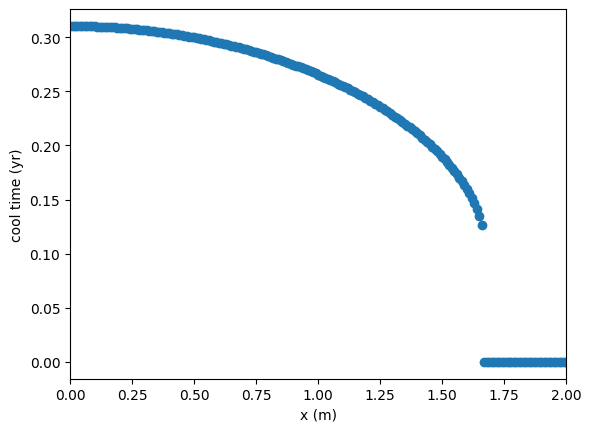

In [63]:
plt.scatter(xx, cool_time)
plt.xlabel('x (m)')
plt.ylabel('cool time (yr)')
plt.xlim(0, w)